<a href="https://colab.research.google.com/github/Mahdi-Miri/Signal_Proccesing/blob/main/Signal_Proccesing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Correlations

###Auto-Correlation

In [1]:
#Pitch Detection In Audio Signals

In [3]:
#Install and Importing libraries


In [6]:
!pip install numpy scipy matplotlib requests

In [6]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import requests
import io
from scipy.signal import find_peaks

In [13]:
# Generate the Audio Signal

# Parameters for the signal
sample_rate = 44100      # Standard sample rate for audio (samples per second)
frequency = 440          # Frequency of the sine wave in Hz (A4 note)
duration = 1.0           # Duration of the signal in seconds

print(f"Generating a synthetic signal with frequency: {frequency} Hz")

# Create a time array from 0 to 'duration' with 'sample_rate' points per second
# This represents the time axis for our signal
t = np.linspace(0., duration, int(sample_rate * duration), endpoint=False)

# Generate the sine wave signal
# The formula for a sine wave is A * sin(2 * pi * f * t)
# We use a simple amplitude of 1.0
data = np.sin(2 * np.pi * frequency * t)

print("Signal generated successfully.")

# Select a small segment of the signal for analysis (e.g., 50ms)
# This is the same process as before
segment_length = int(0.05 * sample_rate)
signal_segment = data[:segment_length]

Generating a synthetic signal with frequency: 440 Hz
Signal generated successfully.


In [14]:
# Compute the autocorrelation using np.correlate
autocorr = np.correlate(signal_segment, signal_segment, mode='full')
# We only need the second half (positive lags)
autocorr = autocorr[len(autocorr)//2:]

In [15]:
# Find all peaks in the autocorrelation function
peaks, _ = find_peaks(autocorr, height=0.1 * np.max(autocorr))

if len(peaks) > 0:
    # The first peak corresponds to the fundamental period
    fundamental_period_samples = peaks[0]

    # Calculate the fundamental frequency (Pitch)
    fundamental_frequency = sample_rate / fundamental_period_samples

    print(f"\nSample Rate: {sample_rate} Hz")
    print(f"Detected Peak Lag: {fundamental_period_samples} samples")
    print(f"Estimated Fundamental Frequency (Pitch): {fundamental_frequency:.2f} Hz")
else:
    print("Could not determine the fundamental frequency.")


Sample Rate: 44100 Hz
Detected Peak Lag: 100 samples
Estimated Fundamental Frequency (Pitch): 441.00 Hz


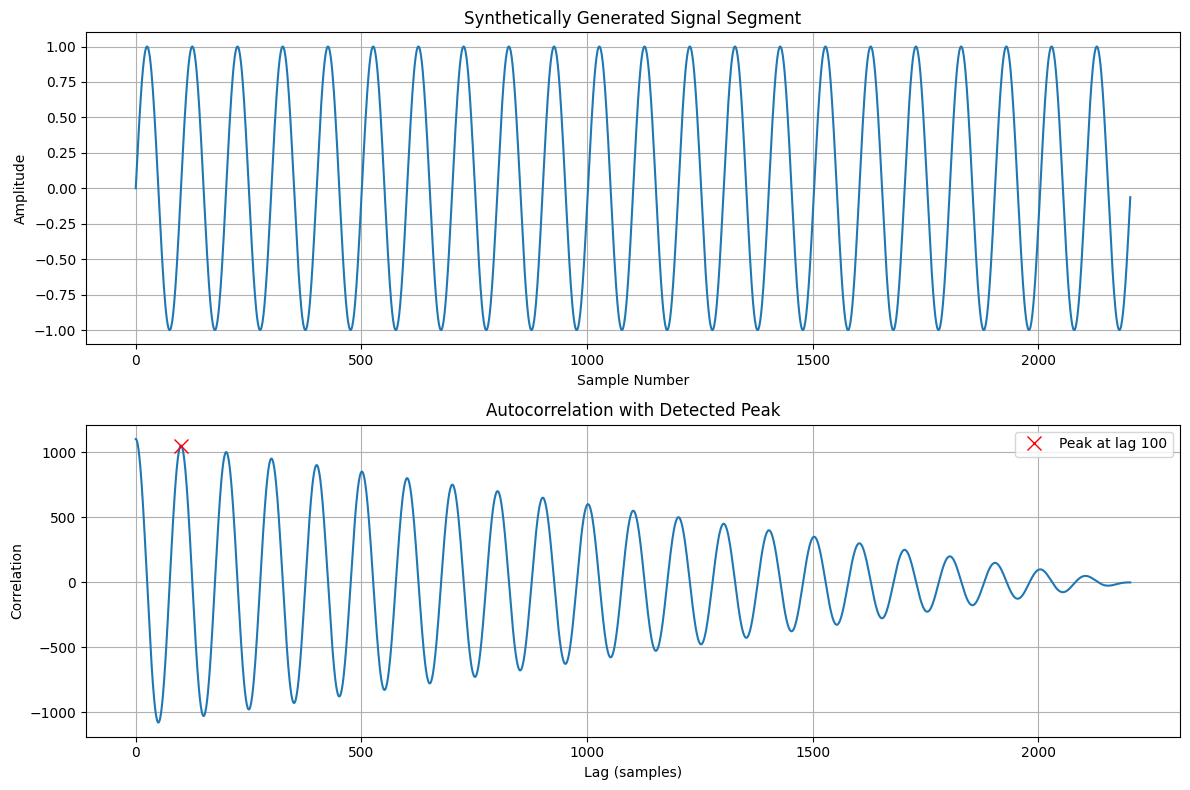

In [16]:
# Plot the signal segment
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.title("Synthetically Generated Signal Segment")
plt.plot(signal_segment)
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot the autocorrelation and the detected peak
plt.subplot(2, 1, 2)
plt.title("Autocorrelation with Detected Peak")
plt.plot(autocorr)
if len(peaks) > 0:
    plt.plot(peaks[0], autocorr[peaks[0]], "x", color='red', markersize=10, label=f'Peak at lag {peaks[0]}')
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
#Frequency=  Sample Rate / Period in Samples  -> 44100 / 100 = 441.0HZ


###Cross-Correlation


In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Define the sample rate
sample_rate = 44100

# 1a: Create the short, known signal (the template we're looking for)
# We'll use a "chirp" signal, which is good for detection because it's unique.
# A chirp is a signal in which the frequency increases or decreases with time.
from scipy.signal import chirp
t_template = np.linspace(0, 0.1, int(0.1 * sample_rate)) # 0.1 seconds long
template_signal = chirp(t_template, f0=1000, f1=2500, t1=0.1, method='linear')
template_signal *= 0.5 # Reduce its amplitude

# 1b: Create the long, main signal with noise
t_main = np.linspace(0, 1.0, int(1.0 * sample_rate)) # 1.0 second long
main_signal = np.random.randn(len(t_main)) * 0.1 # Start with some random noise

# 1c: Hide the template signal somewhere in the main signal
# Let's hide it at 0.6 seconds (embedding_time)
embedding_time = 0.6
start_sample = int(embedding_time * sample_rate)
end_sample = start_sample + len(template_signal)
main_signal[start_sample:end_sample] += template_signal


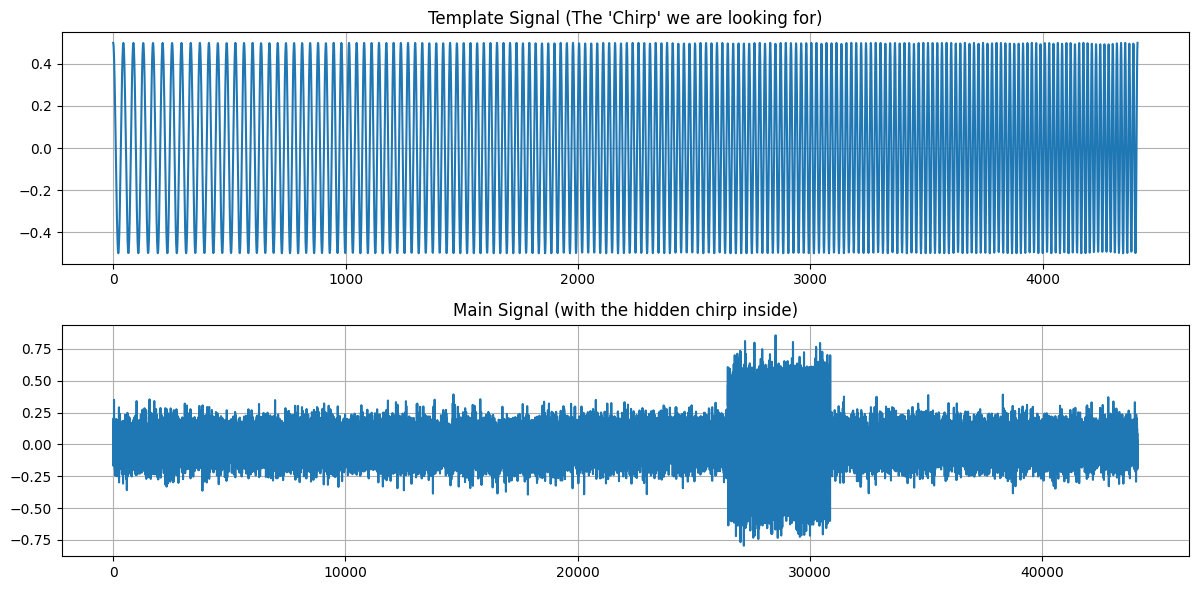

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("Template Signal (The 'Chirp' we are looking for)")
plt.plot(template_signal)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Main Signal (with the hidden chirp inside)")
plt.plot(main_signal)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
cross_correlation = np.correlate(main_signal, template_signal, mode='full')

In [22]:
# Find the index of the maximum value in the correlation result
peak_index = np.argmax(cross_correlation)

# The peak index from 'full' mode needs to be adjusted to find the start of the template
# Lag = Peak Index - (Length of Template - 1)
detected_start_sample = peak_index - (len(template_signal) - 1)

detected_time = detected_start_sample / sample_rate

print(f"The peak of the correlation is at index: {peak_index}")
print(f"The hidden signal is detected to start at sample: {detected_start_sample}")
print(f"This corresponds to a time of: {detected_time:.2f} seconds")

The peak of the correlation is at index: 30869
The hidden signal is detected to start at sample: 26460
This corresponds to a time of: 0.60 seconds


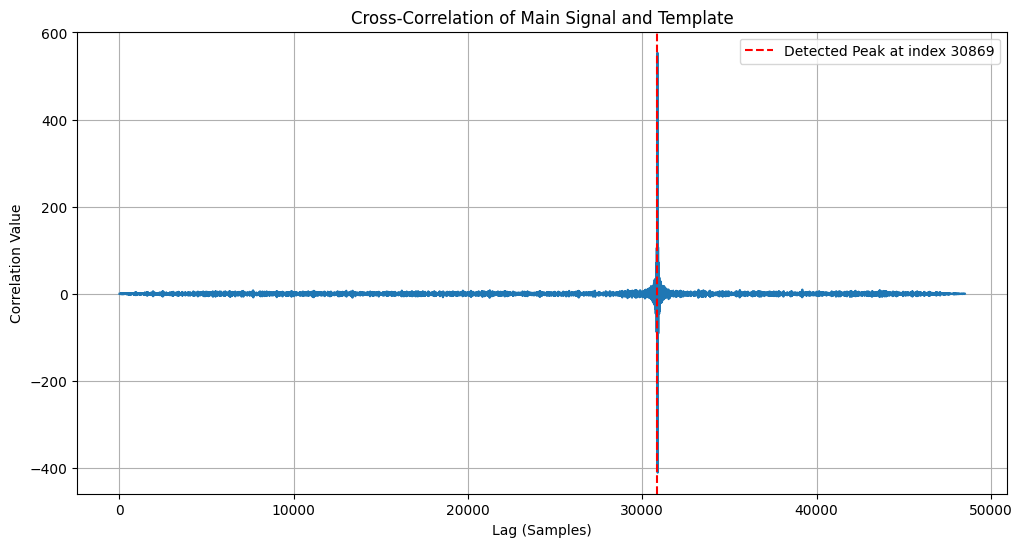

In [23]:
plt.figure(figsize=(12, 6))
plt.title("Cross-Correlation of Main Signal and Template")
plt.plot(cross_correlation)
plt.axvline(peak_index, color='r', linestyle='--', label=f'Detected Peak at index {peak_index}')
plt.xlabel("Lag (Samples)")
plt.ylabel("Correlation Value")
plt.legend()
plt.grid(True)
plt.show()

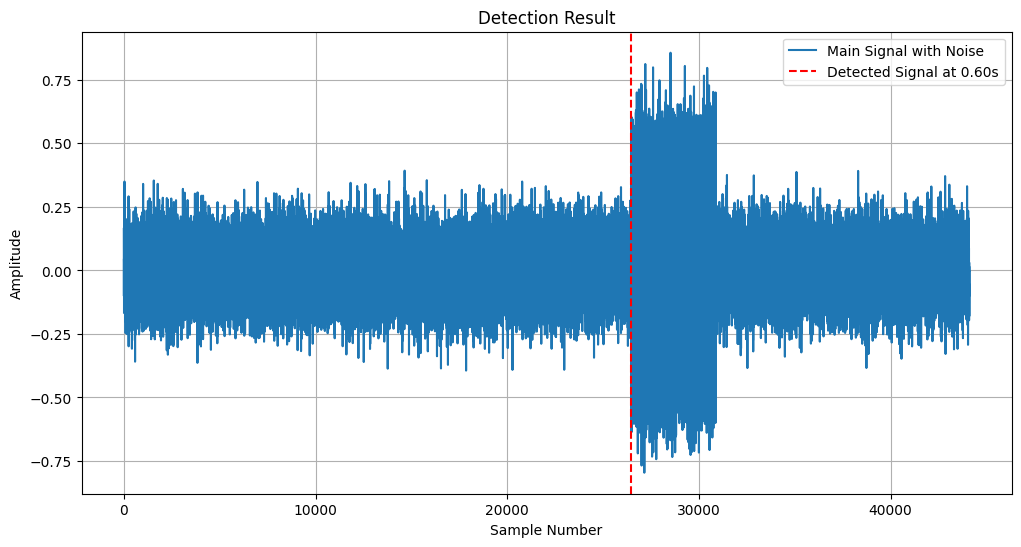

In [24]:
# Plot the main signal again and draw a line where the template was found
plt.figure(figsize=(12, 6))
plt.title("Detection Result")
plt.plot(main_signal, label='Main Signal with Noise')
plt.axvline(detected_start_sample, color='r', linestyle='--', label=f'Detected Signal at {detected_time:.2f}s')
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

##Phase Difference

In [38]:
SAMPLING_RATE = 1000  # Samples per second
DURATION = 2.0        # Seconds
FREQUENCY = 5         # Hertz
# Create the time vector, which is also a constant for all calls
T = np.linspace(0, DURATION, int(SAMPLING_RATE * DURATION), endpoint=False)

In [39]:
def analyze_and_plot_phase_shift(phase_deg, ax_time, ax_freq):
    """
    Analyzes and plots the result of combining two sine waves with a given phase shift.

    Args:
        phase_deg (float): The phase shift in degrees to analyze.
        ax_time (matplotlib.axes.Axes): The subplot for the time-domain plot.
        ax_freq (matplotlib.axes.Axes): The subplot for the frequency-domain plot.
    """
    # --- Signal Generation ---
    phase_rad = np.deg2rad(phase_deg)  # Convert degrees to radians for numpy
    signal1 = np.sin(2 * np.pi * FREQUENCY * T)  # Reference signal with 0 phase
    signal2 = np.sin(2 * np.pi * FREQUENCY * T + phase_rad)  # Signal with the phase shift
    combined_signal = signal1 + signal2  # The result of their interference

    # --- Time Domain Plot (Left Column) ---
    ax_time.plot(T, signal1, 'g--', label='Signal 1 (0°)', alpha=0.6)
    ax_time.plot(T, signal2, 'b--', label=f'Signal 2 ({phase_deg}°)', alpha=0.6)
    ax_time.plot(T, combined_signal, 'r-', linewidth=2.5, label='Combined Signal')
    ax_time.set_title(f'Time Domain: Phase Shift = {phase_deg}°')
    ax_time.set_xlabel('Time (s)')
    ax_time.set_ylabel('Amplitude')
    ax_time.grid(True, linestyle=':')
    ax_time.legend()
    ax_time.set_xlim(0, 2 / FREQUENCY)  # Show 2 full cycles for clarity
    ax_time.set_ylim(-2.1, 2.1)  # Fix y-axis for easy comparison

    # --- Frequency Domain Analysis & Plot (Right Column) ---
    N = len(combined_signal)
    fft_values = np.fft.fft(combined_signal)
    fft_freq = np.fft.fftfreq(N, 1 / SAMPLING_RATE)

    # Calculate the magnitude and get only the positive frequencies
    fft_magnitude = (2.0/N) * np.abs(fft_values[:N//2])
    positive_frequencies = fft_freq[:N//2]

    ax_freq.stem(positive_frequencies, fft_magnitude, basefmt=" ")
    ax_freq.set_title('Frequency Domain (Magnitude)')
    ax_freq.set_xlabel('Frequency (Hz)')
    ax_freq.set_ylabel('Magnitude')
    ax_freq.grid(True, linestyle=':')
    ax_freq.set_xlim(0, FREQUENCY * 2)
    ax_freq.set_ylim(0, 2.1)  # Fix y-axis for easy comparison

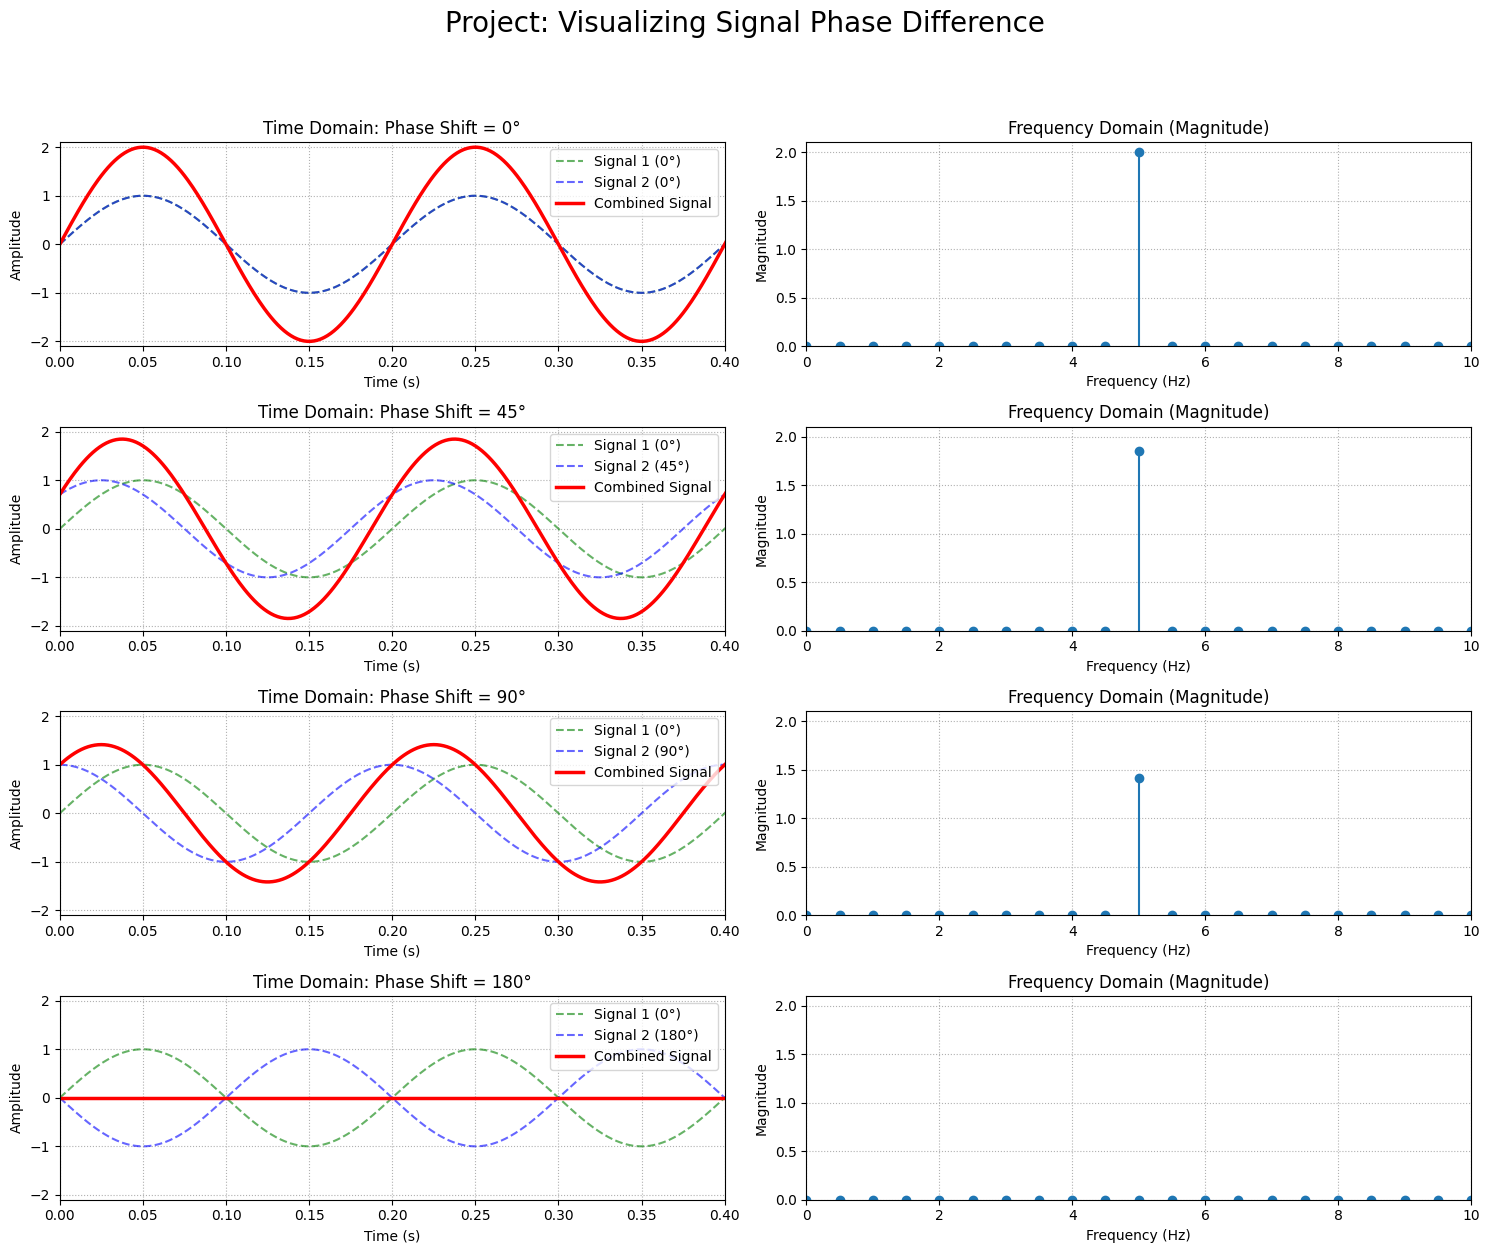

In [40]:
if __name__ == "__main__":

    # Define the list of phase shifts we want to test
    phase_shifts_to_test = [0, 45, 90, 180]

    # Create a figure and a grid of subplots to hold all our charts
    fig, axes = plt.subplots(
        nrows=len(phase_shifts_to_test),
        ncols=2,
        figsize=(15, 13) # A good size for readability
    )
    fig.suptitle('Project: Visualizing Signal Phase Difference', fontsize=20, y=0.99)

    # Loop through our list and call the function for each phase shift
    for i, phase in enumerate(phase_shifts_to_test):
        analyze_and_plot_phase_shift(phase, axes[i, 0], axes[i, 1])

    # Final adjustments for a clean layout and display the plot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()